In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import confusion_matrix

In [2]:
items = os.listdir('dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

In [3]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {}
        for dog_category in dog_categories:
                self._data[dog_category] = {
                        'vrai positif': 0,
                        'faux positif': 0,
                        'precision':0
                    }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                if test == prediction:
                    self._data[dog_categories[test]]['vrai positif'] = self._data[dog_categories[test]]['vrai positif'] + 1
                if test != prediction:
                    self._data[dog_categories[prediction]]['faux positif'] = self._data[dog_categories[prediction]]['faux positif'] + 1
                    
                self._data[dog_categories[test]]['precision'] = self._data[dog_categories[test]]['vrai positif'] / (self._data[dog_categories[test]]['vrai positif'] + self._data[dog_categories[prediction]]['faux positif'])
        return

    def get_data(self):
        return self._data

In [4]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Je charge mes datasets

In [5]:
BATCH_SIZE = 32
IMG_SIZE = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classe en one hot

In [7]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=120)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Utilisation de mobilenet v2

In [9]:
base_model = keras.applications.ResNet50V2(
                        include_top=False, # Exclude ImageNet classifier at the top
                        weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)
                        )

In [10]:
base_model.trainable = False
# base_model.summary()

Pour générer des prédictions à partir du bloc d'entités, effectuez une moyenne sur les emplacements spatiaux 5x5 , à l'aide d'une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les entités en un seul vecteur de 1 280 éléments par image.

On construit le modèle

In [11]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model = keras.Model(inputs, outputs)

In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [14]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [15]:
metrics = Metrics(val_data = validation_dataset, dog_categories = dog_categories)

In [16]:
EPOCHS = 25

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    verbose=1,
                    callbacks =[earlystopping, metrics])

Epoch 1/25
449/449 [==============================] - 193s 417ms/step - loss: 2.2749 - categorical_accuracy: 0.4447 - val_loss: 1.0463 - val_categorical_accuracy: 0.6999
Epoch 2/25
449/449 [==============================] - 186s 415ms/step - loss: 1.4737 - categorical_accuracy: 0.6036 - val_loss: 1.0169 - val_categorical_accuracy: 0.7061
Epoch 3/25
449/449 [==============================] - 185s 411ms/step - loss: 1.2896 - categorical_accuracy: 0.6467 - val_loss: 1.0181 - val_categorical_accuracy: 0.7108
Epoch 4/25
449/449 [==============================] - 186s 414ms/step - loss: 1.1739 - categorical_accuracy: 0.6737 - val_loss: 1.0251 - val_categorical_accuracy: 0.7150
Epoch 5/25
449/449 [==============================] - 186s 414ms/step - loss: 1.0965 - categorical_accuracy: 0.6910 - val_loss: 1.0631 - val_categorical_accuracy: 0.7152
Epoch 6/25
449/449 [==============================] - 185s 411ms/step - loss: 1.0301 - categorical_accuracy: 0.7078 - val_loss: 1.0322 - val_categoric

In [17]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 158,
  'faux positif': 99,
  'precision': 0.6147859922178989},
 'Japanese_spaniel': {'vrai positif': 257,
  'faux positif': 53,
  'precision': 0.7740963855421686},
 'Maltese_dog': {'vrai positif': 309,
  'faux positif': 57,
  'precision': 0.8442622950819673},
 'Pekinese': {'vrai positif': 159,
  'faux positif': 30,
  'precision': 0.8412698412698413},
 'Shih': {'vrai positif': 180,
  'faux positif': 171,
  'precision': 0.5278592375366569},
 'Blenheim_spaniel': {'vrai positif': 257,
  'faux positif': 48,
  'precision': 0.8158730158730159},
 'papillon': {'vrai positif': 312,
  'faux positif': 75,
  'precision': 0.8082901554404145},
 'toy_terrier': {'vrai positif': 237,
  'faux positif': 107,
  'precision': 0.6950146627565983},
 'Rhodesian_ridgeback': {'vrai positif': 150,
  'faux positif': 102,
  'precision': 0.8928571428571429},
 'Afghan_hound': {'vrai positif': 391,
  'faux positif': 78,
  'precision': 0.8336886993603412},
 'basset': {'vrai positif': 206,


In [18]:
loss0, accuracy0 = model.evaluate(test_dataset)

34/34 [==============================] - 5s 135ms/step - loss: 0.9775 - categorical_accuracy: 0.7233


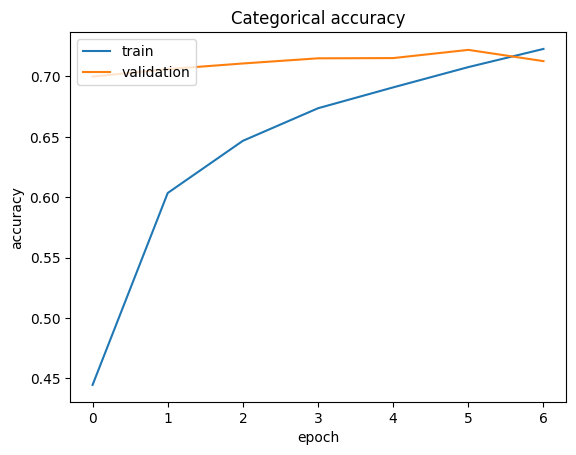

In [19]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [20]:
model.save('Modele_transfert.h5')